In [14]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\CreatingDataset\\cleaned\\acroeconomic_classifier_dataset_4_hypercleaned.csv'
                 )
# Convert all sentences to strings and handle NaN values
df['sentence'] = df['sentence'].astype(str).fillna('')
texts = df['sentence'].tolist()

In [6]:
# Load the trained classifier and TF-IDF vectorizer
clf_model_path = 'E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\Hybrid Model\\hybrid_classifier_tfidf.joblib'
tfidf_vectorizer_path = 'E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\Hybrid Model\\tfidf_vectorizer.joblib'
loaded_clf = joblib.load(clf_model_path)
tfidf_vectorizer = joblib.load(tfidf_vectorizer_path)

In [7]:
# Load the tokenizer and model for FinBERT
hybrid_finbert_tokenizer_path = 'E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\Hybrid Model\\finbert_macroecon_tokenizer'
hybrid_finbert_model_path = 'E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\Hybrid Model\\finbert_macroecon_classifier'
hybrid_finbert_tokenizer = AutoTokenizer.from_pretrained(hybrid_finbert_tokenizer_path)
hybrid_finbert_model = AutoModel.from_pretrained(hybrid_finbert_model_path)

In [8]:
# Function to get embeddings from FinBERT
def get_embeddings(texts, model, tokenizer):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return embeddings

In [11]:
# Function to preprocess and predict a new sentence
def predict_category(new_sentence):
    # Preprocess the new sentence
    embeddings = get_embeddings([new_sentence], hybrid_finbert_model, hybrid_finbert_tokenizer)
    tfidf_features = tfidf_vectorizer.transform([new_sentence]).toarray()
    
    # Combine FinBERT embeddings with TF-IDF features
    combined_features = np.hstack((embeddings, tfidf_features))
    
    # Make prediction
    prediction = loaded_clf.predict(combined_features)
    return prediction[0]

In [13]:
df['hybrid_prediction']=[predict_category(text) for text in texts]
df.to_csv('acroeconomic_classifier_dataset_4_hypercleaned_with_hybrid_prediction.csv', index=False)

In [15]:
df = pd.read_csv('acroeconomic_classifier_dataset_4_hypercleaned_with_hybrid_prediction.csv')

In [18]:
# Extract the true labels and predictions
true_labels = df['label'].tolist()  # Replace 'label' with the actual column name if different
predictions = df['hybrid_prediction'].tolist()

In [19]:
# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')
report = classification_report(true_labels, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Classification Report:")
print(report)

Accuracy: 0.9092575618698442
Precision: 0.9109179447527734
Recall: 0.9092575618698442
F1 Score: 0.9088731842568836
Classification Report:
                     precision    recall  f1-score   support

     Exchange Rates       0.88      0.83      0.85        35
      Fiscal Policy       0.91      0.93      0.92       336
         GDP Growth       0.94      0.74      0.83        78
          Inflation       0.94      0.96      0.95       193
International Trade       0.82      0.91      0.86       136
    Monetary Policy       0.93      0.90      0.92       284
       Unemployment       0.93      0.93      0.93        29

           accuracy                           0.91      1091
          macro avg       0.91      0.89      0.89      1091
       weighted avg       0.91      0.91      0.91      1091


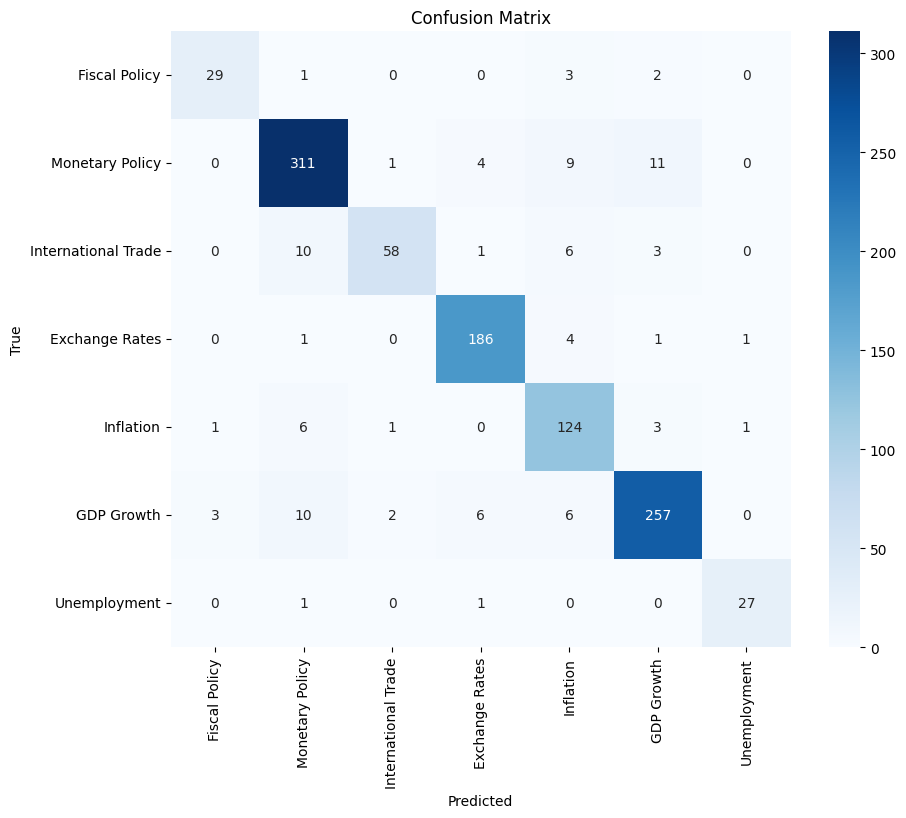

In [20]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['label'].unique(), yticklabels=df['label'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()